In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.2 MB/s 
     |████████████████████████████████| 182 kB 72.0 MB/s 
     |████████████████████████████████| 7.6 MB 27.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BasicTokenizer
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
def read_file(file_name):
    f = open(file_name, "r")
    full_text = f.read().split(";||;")
    dataset=[]
    label=[]
    count=1
    for i in full_text:
      if count%2 == 0:
        dataset.append(i.strip())
        count=count+1
      else:
        i=i.split("\n")
        label.append(i[0])
        count=count+1
    label.pop(0)
    return dataset,label

In [4]:
data,label=read_file("labeled_corpus_6K(1).txt")

In [5]:
label=[int(i) for i in label]

In [6]:
print(len(data))
print(len(label))

6000
6000


In [7]:
def clean_dataset(value):
  dataset=[]
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  for i in value:
    text=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i)
    text=emoji_pattern.sub(r'', text)
    text=text.lower()
    dataset.append(text)
  return dataset

In [8]:
clean_data=clean_dataset(data)

In [9]:
print(len(clean_data))

6000


In [10]:
clean_data[12]

'rovira lleva siendo subnormal desde 1980'

In [11]:
train_data = clean_data[:5000]
test_data = clean_data[5000:]

In [12]:
train_data[0]

'ismael es egocentrico porque se vuelve loca si le dicen que tiene el pelo bonito eso se define con otro objetivo firstdates251'

In [13]:
train_label= label[:5000]
test_label = label[5000:]

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [15]:
def convert_data_into_input_example(data,label_value):
    input_examples = []
    for i in range(len(data)):
        example = InputExample(
            guid= None,
            text_a= data[i],
            text_b= None,
            label= label_value[i]
        )
        input_examples.append(example)
    return input_examples

In [16]:
train_input_examples = convert_data_into_input_example(train_data,train_label)
val_input_examples = convert_data_into_input_example(test_data,test_label)

In [17]:
len(train_input_examples)

5000

In [18]:
label_list = [0, 1]
bert_train_dataset = glue_convert_examples_to_features(examples=train_input_examples, tokenizer=tokenizer, max_length=128, task='mrpc', label_list=label_list)
bert_val_dataset = glue_convert_examples_to_features(examples=val_input_examples, tokenizer=tokenizer, max_length=128, task='mrpc', label_list=label_list)

/usr/local/lib/python3.8/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.8/dist-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [19]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
for i in range(3):
    print(bert_train_dataset[i])

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


InputFeatures(input_ids=[101, 10124, 92212, 10196, 31367, 25907, 21643, 16348, 10126, 50837, 23669, 10113, 10294, 10141, 20730, 10115, 10121, 12832, 10125, 11904, 22873, 12390, 36584, 10126, 39224, 10173, 16694, 23518, 10422, 81921, 10107, 69168, 10759, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
def my_solution(bdset):
    
    input_ids, attention_mask, token_type_ids, label = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        label.append(in_ex.label)

    input_ids = np.vstack(input_ids)
    attention_mask = np.vstack(attention_mask)
    token_type_ids = np.vstack(token_type_ids)
    label = np.vstack(label)
    return ([input_ids, attention_mask, token_type_ids], label)

In [21]:
x_train, y_train = my_solution(bert_train_dataset)
x_val, y_val = my_solution(bert_val_dataset)

print('x_val size: {}'.format(len(x_val)))
def example_to_features(input_ids, attention_masks, token_type_ids, y):
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids},y


train_ds = tf.data.Dataset.from_tensor_slices((x_train[0], x_train[1], x_train[2], y_train)).map(example_to_features).shuffle(100).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val[0], x_val[1], x_val[2], y_val)).map(example_to_features).batch(64)

print('format of model input examples: '.format(train_ds.take(1)))

EPOCHS = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

x_val size: 3
format of model input examples: 
Epoch 1/5
157/157 [==============================] - 162s 885ms/step - loss: 0.5501 - accuracy: 0.7350 - val_loss: 0.5107 - val_accuracy: 0.7510
Epoch 2/5
157/157 [==============================] - 136s 869ms/step - loss: 0.4507 - accuracy: 0.7864 - val_loss: 0.4610 - val_accuracy: 0.8020
Epoch 3/5
157/157 [==============================] - 136s 869ms/step - loss: 0.3757 - accuracy: 0.8428 - val_loss: 0.4421 - val_accuracy: 0.8020
Epoch 4/5
157/157 [==============================] - 137s 870ms/step - loss: 0.2570 - accuracy: 0.9018 - val_loss: 0.5110 - val_accuracy: 0.8060
Epoch 5/5
157/157 [==============================] - 136s 869ms/step - loss: 0.1670 - accuracy: 0.9438 - val_loss: 0.6889 - val_accuracy: 0.7970


In [22]:
MAX_SEQ_LENGTH = 128

def example_to_features_predict(input_ids, attention_masks, token_type_ids):
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids}


In [23]:
print(len(list(val_ds)))
predictions = model.predict(val_ds)
print(predictions[0].shape)
print()
predictions_classes = np.argmax(predictions[0], axis = 1)
predicted_label=[]
original_label=[]
for i in range(len(test_data)):
    predicted_label.append(val_input_examples[i].label)
    original_label.append(predictions_classes[i])

16
16/16 [==============================] - 11s 508ms/step
(1000, 2)



In [24]:
len(predicted_label)

1000

In [25]:
len(original_label)

1000

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(original_label, predicted_label)

0.797

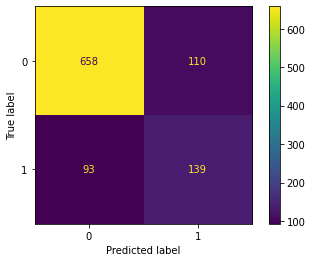

In [28]:
cm = confusion_matrix(original_label, predicted_label, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.savefig('confusion_matroix.png')
plt.show()